In [10]:
import simpy
import networkx as nx

import itertools
import requests
import pickle
import io

import pandas as pd
import geopandas as gpd

import simpy

import itertools

import matplotlib.pyplot as plt

import pint
ureg = pint.UnitRegistry()

In [2]:
url = 'https://zenodo.org/records/6673604/files/network_digital_twin_v0.3.pickle?download=1'
resp = requests.get(url)

In [3]:
graph = pickle.load(io.BytesIO(resp.content))

In [4]:
rotterdam_nijmegen = {
    "teu": 10,
    "source": "18008346",
    "source_name": "Rotterdam", 
    "target": "22638188",
    "target_name": "Nijmegen"
}
rotterdam_duisburg = {
    "teu": 10,
    "source": "18008346",
    "source_name": "Rotterdam", 
    "target": "FN96",
    "target_name": "Duisburg"
}


369417.8811097597

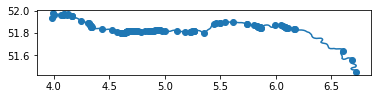

In [5]:

def get_route_gdfs(scenario):
    route = nx.shortest_path(graph, source=scenario["source"], target=scenario["target"], weight="length_m")


    nodes = []
    for n in route:
        node = graph.nodes[n]
        nodes.append(node)
    
    node_df = pd.DataFrame(nodes)
    geometry = gpd.GeoSeries.from_wkt(node_df['Wkt'])
    node_gdf = gpd.GeoDataFrame(node_df, geometry=geometry)

    edges = []
    for a, b in zip(route[:-1], route[1:]):
        edge = graph.edges[(a, b)]
        edges.append(edge)

    edge_df = pd.DataFrame(edges)
    geometry = gpd.GeoSeries.from_wkt(edge_df['Wkt'])
    edge_gdf = gpd.GeoDataFrame(edge_df, geometry=geometry)
    
    
    result = {"edge": edge_gdf, "node": node_gdf}
    return result

scenario = rotterdam_duisburg

route_gdfs = get_route_gdfs(scenario)
edge_gdf = route_gdfs["edge"]
node_gdf = route_gdfs["node"]

fig, ax = plt.subplots()

edge_gdf.plot(ax=ax)
node_gdf.plot(ax=ax)
    
edge_gdf["length_m"].sum()

In [13]:
def transport(env, scenario):
    route_gdfs = get_route_gdfs(scenario)
    edge_gdf = route_gdfs["edge"]
    node_gdf = route_gdfs["node"]

    route_length_m = edge_gdf["length_m"].sum()
    velocity = 4
    duration = route_length_m / velocity # m / m/s = m * s / m = s
    yield env.timeout(duration)
    
    


In [14]:
env = simpy.Environment()
env.process(transport(env, scenario))
env.run()
(env.now * ureg.seconds).to(ureg.hours)

25.65401952151109 <Unit('hour')>